> # Neural Network Basic - Week3 과제


## Import Library

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from dataset.mnist import load_mnist

## Load Dataset
- MNIST 

In [9]:
(X_train, Y_train), (X_test, Y_test) = \
    load_mnist(normalize=True, one_hot_label=False)

In [10]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'Y_train shape: {Y_test.shape}')

X_train shape: (60000, 784)
X_test shape: (10000, 784)
Y_train shape: (60000,)
Y_train shape: (10000,)


## Activation Function 
- sigmoid & relu : hidden layer activation function 
- softmax : output layer activation function 

In [11]:
class sigmoid:
    # sigmoid 함수를 작성하세요 
    def forward(x):
        global y
        y = 1 / (1 + np.exp(-x))
        return y
    
    # sigmoid 함수의 미분을 작성하세요
    def backward(x):
        dx = x * y * (1 - y)
        return dx

In [24]:
class relu:
    # relu 함수를 작성하세요
    def forward(x):
        global mask
        mask = (x <= 0)
        out = x.copy()
        out[mask] = 0
        return out
    
    # relu 함수의 미분을 작성하세요
    def backward(x):
        x[mask] = 0
        return x

In [13]:
class softmax:
    def forward(z):
        y = []
        for zi in z:
            c = np.max(zi)
            exp_zi = np.exp(zi-c)
            sum_exp_zi = np.sum(exp_zi)
            yi = exp_zi / sum_exp_zi
            y.append(yi)

        return np.array(y)
    
    def backward(p, y) :
        dp = p.copy()
        for dpi, yi in zip(dp, y):
            for k in range(dp.shape[1]):
                if k == yi :
                    dpi[k] -= 1
        return dp

## Loss Function

In [14]:
def cross_entropy(p, y):
    loss = []
    for pi, yi in zip(p, y):
        for k in range(p.shape[1]):
            if k == yi:
                loss.append((-1) * (np.log(pi[k] + 1e-8))) 
    return loss

## Layer

In [15]:
class Layer:
    def __init__(self, input_size, output_size, std=1e-4) :
        self.input_size = input_size
        self.output_size = output_size
        self.bias = np.random.randn(output_size)
        self.weight = np.random.randn(input_size, output_size)*std

## Neural Network
- 각 메소드와 변수들의 역할을 주석으로 달아주세요! 

In [26]:
class CustomNet:
    # CustomNet을 선언할 때 생성되는 값들입니다.
    def __init__(self, lr=0.0001, epoch=500, batch_size=200): # learning rate : 0.0001, epoch : 500, batch size : 200
        self.lr = lr  # 0.0001
        self.epoch = epoch  # 500
        self.batch_size = batch_size  # 200
        self.loss_function = cross_entropy  # loss function으로 cross entropy 함수 사용
        self.layers = []  # 층 초기화
        self.activations = [softmax]  # 활성화 함수 : softmax 함수
        self.nodes = []  # 각 노드들의 값들을 저장하기 위해 리스트 초기화
    
    # Layer를 추가할 때 호출합니다
    def addLayer(self, Layer): 
        self.layers.append(Layer)  # Layer 클래스를 self.layers 리스트에 추가
        if not self.nodes:  # self.nodes 리스트가 비워있는 경우 
            self.nodes.append(np.zeros(Layer.input_size)) # Layer의 input size 만큼의 0벡터를 self.nodes 리스트에 append
        self.nodes.append(np.zeros(Layer.output_size)) # Layer의 output size 만큼의 0벡터를 self.nodes 리스트에 append
        
    # Activation Function을 추가할 때 호출합니다
    def addActivation(self, Activation): 
        tmp = self.activations.pop() # softmax를 pop함과 동시에 tmp변수에 저장
        self.activations.append(Activation) # 추가할 Activation Function을 self.activations 리스트에 추가
        self.activations.append(tmp) # softmax를 그 뒤에 똑같이 추가
        
    # 순전파 함수
    def _forward(self, X): # X : 입력값 (input data)
        self.nodes[0] = X.copy() # 노드의 첫번 째 행을 X 즉, input data로 대체
        output = X.copy() # output 변수에 X 즉, input data를 저장
        for i in range(len(self.layers)): # layer의 수만큼 반복
            Layer = self.layers[i] # layer를 Layer변수에 저장
            Activation = self.activations[i] # 해당 index의 활성화함수를 사용 ex) sigmoid, softmax
            output = np.dot(self.nodes[i], Layer.weight) # input data와 해당 층의 가중치를 내적 -> 그 값을 output변수에 저장
            output = output+ Layer.bias # 가중치와 내적한 값에 편향을 더함
            output = Activation.forward(output) # 위에서 불러온 활성화 함수를 적용한 후 그 값을 output변수에 저장 
            self.nodes[i+1] = output # 노드의 다음번 째 행을 output 값으로 대체
        return output  # output 값을 return
    
    # 역전파 함수
    def _backward(self, X, output, y) : 
        for i in reversed(range(len(self.layers))): # 역전파는 출력층에서부터 거꾸로 계산하기 때문에 range를 reverse하여 뒤에서 부터 계산
            a = self.nodes[i+1]  # 노드의 가장 끝 값부터 a변수에 저장
            Layer = self.layers[i]  # self.layers 리스트의 끝 값부터 가져와 Layer변수에 저장
            Activation = self.activations[i]  # activation 리스트의 마지막 활성화 함수부터 가져와 Activation 변수에 저장
            
            if i+1 == len(self.layers): # 해당 index의 층이 가장 끝의 층인 경우
                error = Activation.backward(output, y)  # Activation 함수는 Softmax이므로 output값과 라벨 값을 파라미터로 받아 error변수에 저장
            else:
                error *= Activation.backward(a) # Activation 함수가 Sifgmoid 함수이므로 해당 노드를 파라미터로 받아 error에 곱함
            Layer.weight -= np.dot(error.T, self.nodes[i]).T*self.lr/X.shape[0]
            # weight의 역전파를 구하는 방식인 error의 transpose 값과 노드를 내적한 후 그 값을 다시 transopose 하고 learning rate를 곱한 후
            # X의 크기로 나누어 Layer의 가중치를 구한다.
            Layer.bias -= error.sum(axis=0)*self.lr/X.shape[0]
            # 층의 편향을 구하기 위해 error를 행 기준 모두 더하여 똑같이 learning rate를 곱한 후 X의 크기로 나눈 값을 빼준다.
            error = np.dot(error, Layer.weight.T) # error를 구하기 위해 해당 error와 가중치의 전치 값을 내적하여 받아준다.
            
    # Accrucy를 반환합니다
    def _accuracy(self, output, y):
        pre_p = np.argmax(output, axis=1) # 출력값 중 가장 확률이 높은 값의 인덱스를 pre_p 로 저장
        return np.sum(pre_p==y)/y.shape[0] # 정답을 맞춘 것의 개수를 총 데이터의 개수로 나누어 정확도를 계산한 후 return
    
    # 데이터셋에 모델을 fit할때 호출합니다
    def fit(self, X, y, val_X, val_y):
        history = {'val_acc': [],'val_loss': []} # 후에 출력할 validation accuracy와 validation loss값에 대한 폼을 미리 저장
        N = X.shape[0] # 데이터의 개수 : N
        for i in range(self.epoch): # epoch 수만 큼 반복
            for j in range(N//self.batch_size): # 총 데이터의 개수를 batch size로 나눈 만큼 반복
                batch_mask = np.random.choice(N, self.batch_size) # 총 데이터의 개수 중 batch size만큼 random 하게 선택해 batch의 인덱스를 구한다.
                X_batch = X[batch_mask] # batch X 값을 저장
                y_batch = y[batch_mask] # batch Y 값을 저장
                output = self._forward(X_batch) # batch X 행렬을 순전파 진행한 후 output변수에 저장
                self._backward(X_batch, output, y_batch) # 입력값과 출력값 정답을 파라미터로 주어 역전파 진행
            
            #accuracy와 loss를 기록해둡시다
            output = self._forward(val_X) # 검증 데이터의 입력값에 대한 출력값을 output변수에 저장
            history["val_acc"].append(self._accuracy(output, val_y)) # 검증 데이터의 출력값과 정답을 비교하여 accuracy를 구한다.
            history["val_loss"].append(sum(self.loss_function(output, val_y))) # 출력값과 라벨값을 사용하여 손실함수 값을 구한다.
            
            #중간중간 기록을 찍어볼 때 사용. 적절히 조절해 쓰세요
            if i % 10 == 0: # epoch이 10단위 수일 때의 정확도와 손실함수 값을 출력
                print(i, "test accuracy :", history["val_acc"][-1])
                print(i, "test loss     :", history["val_loss"][-1])
        return history

## Customizing
- Network parameter, Layer architecture, Activation function .. 등등 다양한 하이퍼파라미터를 커스터마이징하여 높은 성능에 도달해 봅시다! 

In [102]:
# 하이퍼파라미터를 적절히 조절해 뉴럴넷을 선언하세요
nn = CustomNet(lr=0.01, epoch=50, batch_size=400)

# 원하는 만큼 층과 활성화 함수를 쌓아 주세요. 기본적으로 2Layer를 예시로 적어드립니다
nn.addLayer(Layer(784,100))
nn.addActivation(relu)
nn.addLayer(Layer(100,10))

In [103]:
# 선언한 뉴럴넷의 구조입니다
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(784, 100) (100,)
(100, 10) (10,)


In [104]:
history = nn.fit(X_train, Y_train, X_test, Y_test)

0 test accuracy : 0.239
0 test loss     : 22659.634861903818
10 test accuracy : 0.8011
10 test loss     : 6467.579259438381
20 test accuracy : 0.8838
20 test loss     : 3888.3250806206997
30 test accuracy : 0.9046
30 test loss     : 3283.308695088163
40 test accuracy : 0.9124
40 test loss     : 3063.962219756773


In [99]:
print(history)

{'val_acc': [0.1479, 0.3288, 0.5003, 0.5913, 0.7652, 0.8441, 0.8743, 0.8799, 0.8932, 0.8996, 0.9025, 0.9073, 0.9094, 0.9099, 0.9097, 0.9132, 0.9121, 0.916, 0.9167, 0.9123, 0.9179, 0.9178, 0.9159, 0.9166, 0.9211, 0.9207, 0.9165, 0.9226, 0.9203, 0.9206, 0.9217, 0.9232, 0.9242, 0.9228, 0.923, 0.9237, 0.9203, 0.9256, 0.9232, 0.9277, 0.9216, 0.9261, 0.9244, 0.9276, 0.9229, 0.9116, 0.9242, 0.9253, 0.9242, 0.9168, 0.8039, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098, 0.098], 'val_loss': [21732.978142894914, 19173.860549419183, 14334.303913048521, 11496.859938752377, 7755.096301610637, 5523.723396494344, 4565.802634601983, 4173.878023226901, 3832.7163576427724, 3583.4771004218287, 3436.8352741084104, 3295.705

## Accuracy, Loss Visualization
- 자유롭게 Accuracy나 Loss를 시각화하여 확인하고 결과를 확인해 보세요! 

In [100]:
%matplotlib inline 
import matplotlib.pyplot as plt

# lr=0.01, epoch=100, batch_size=200

최대 정확도 : 0.9277


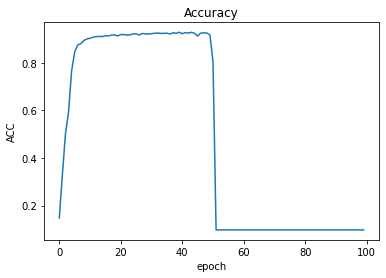

In [101]:
X = list(range(100))
y = history['val_acc']
print(f'최대 정확도 : {max(y)}')

plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('ACC')
plt.plot(X,y)

최소 loss값 : 21699.486534616593


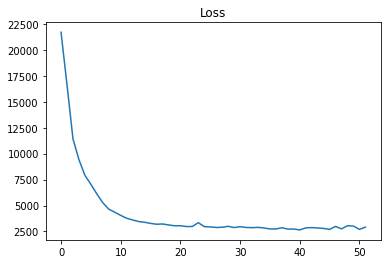

In [84]:
X = list(range(100))
y = history['val_loss']
print(f'최소 loss값 : {max(y)}')

plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.plot(X,y)

# lr=0.01, epoch=50, batch_size=400

최대 정확도 : 0.9176


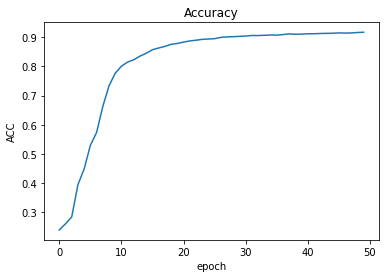

In [106]:
X = list(range(50))
y = history['val_acc']
print(f'최대 정확도 : {max(y)}')

plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('ACC')
plt.plot(X,y)

최소 loss값 : 22659.634861903818


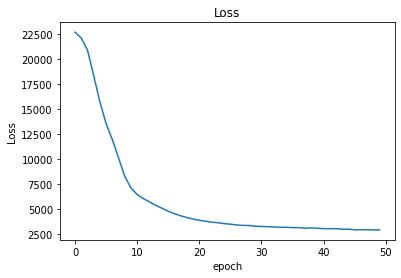

In [107]:
X = list(range(50))
y = history['val_loss']
print(f'최소 loss값 : {max(y)}')

plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.plot(X,y)